# Input Driven HMM

This notebook is a simple example of an HMM with exogenous inputs.  The inputs modulate the probability of discrete state transitions via a multiclass logistic regression. Let $z_t \in \{1, \ldots, K\}$ denote the discrete latent state at time $t$ and $u_t \in \mathbb{R}^U$ be the exogenous input at time~$t$.  The transition probability is given by,

$$
\begin{align}
\Pr(z_t = k \mid z_{t-1} = j, u_t) = 
\frac{\exp\{\log P_{j,k} + w_k^\mathsf{T} u_t\}}
{\sum_{k'=1}^K \exp\{\log P_{j,k'} + w_{k'}^\mathsf{T} u_t\}}.
\end{align}
$$

The parameters of the transition model are $P \in \mathbb{R}_+^{K \times K}$, a baseline set of (unnormalized) transition weights, and $W \in \mathbb{R}^{K \times U}$, a set of input weights. 

In [6]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from ssm.models import HMM
from ssm.util import one_hot, find_permutation

%matplotlib inline

import math
# npr.seed(0)

In [7]:
#hybrid Gaussian process for angle time series
def d_theta(alpha, dc_perp, K, w, dC):
    '''
    Return change in theta angle for each step
    Input with alpha for weighting, dc for orthogonal concentration difference, and K covariance in weathervaning
    W as the weighting/kernel on concentration in the signoidal function for tumbling rate 
    '''
    wv = alpha*dc_perp + K*np.random.randn()  #weathervaning strategy
    #P_event = 0.023/(0.4 + np.exp(140*dC/dt)) + 0.003  #sigmoidal function with parameters w
    P_event = 5*0.023/(1 + np.exp(140*(dC/dt) + 0))  #less parameter version
    if np.random.rand() < P_event:
        beta = 1
    else:
        beta = 0
    rt = beta*(np.random.rand()*360 - 180) #(2*np.pi)  #run-and-tumble strategy
    #rt = beta*(np.random.randn()*K + 100)  #alternative Gaussian mixture
    dth = wv + rt
    if dth > 180:
        dth = dth-360  #bounded by angle measurements
    if dth < -180:
        dth = dth+360
    return dth

In [12]:
#gradient environment
dis2targ = 50
C0 = 0.2
D = 0.000015
duT = 60*60*3
d = 0.18
def gradient(C0,x,y):
    concentration = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))  #depends on diffusion conditions
    return concentration

In [13]:
#measure for concentration difference for weathervane
def dc_measure(dxy,xx,yy):
    perp_dir = np.array([-dxy[1], dxy[0]])
    perp_dir = perp_dir/np.linalg.norm(perp_dir)
    perp_dC = gradient(C0, xx+perp_dir[0], yy+perp_dir[1]) - gradient(C0, xx-perp_dir[0], yy-perp_dir[1])
    return perp_dC

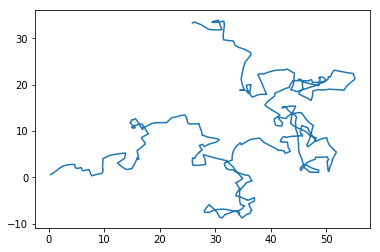

In [132]:
alpha = 25  #strength of OU forcing
K = 5  #covariance of weathervane
w = 0  #logistic parameter (default for now)
T = 5000
dt = 0.6  #seconds
v_m = 0.12  #mm/s
v_s = 0.01  #std of speed
time = np.arange(0,T*dt,dt)
xs = np.zeros(time.shape)
ys = np.zeros(time.shape)  #2D location
xs[0] = np.random.randn()
ys[0] = np.random.randn()
ths = np.zeros(time.shape)  #agle with 1,0
ths[0] = np.random.randn()
dxy = np.random.randn(2)
dcs = np.zeros(time.shape)
dcps = np.zeros(time.shape)
dths = np.zeros(time.shape)

#with turning (Brownian-like tragectories)
for t in range(1,len(time)):
    
    #concentration = gradient(C0,xs[t-1],ys[t-1])
    dC = gradient(C0, xs[t-1],ys[t-1]) - gradient(C0, xs[t-2],ys[t-2])
    dc_perp = dc_measure(dxy,xs[t-1],ys[t-1])      
    dth = d_theta(alpha, -dc_perp, K, 0, dC)
    ths[t] = ths[t-1] + dth*dt
    
    dcs[t] = dC
    dcps[t] = dc_perp
    dths[t] = dth
    
    e1 = np.array([1,0])
    vec = np.array([xs[t-1],ys[t-1]])
    theta = math.acos(np.clip(np.dot(vec,e1)/np.linalg.norm(vec)/np.linalg.norm(e1), -1, 1)) #current orienation relative to (1,0)

    vv = v_m + v_s*np.random.randn()
    dd = np.array([vv*np.sin(ths[t]*np.pi/180), vv*np.cos(ths[t]*np.pi/180)])  #displacement
    c, s = np.cos(theta), np.sin(theta)
    R = np.array(((c,s), (-s, c)))  #rotation matrix, changing coordinates
    dxy = np.dot(R,dd)
    
    xs[t] = xs[t-1] + dxy[0]*dt
    ys[t] = ys[t-1] + dxy[1]*dt

    
#plt.plot(ths)
plt.figure()
plt.plot(xs,ys)

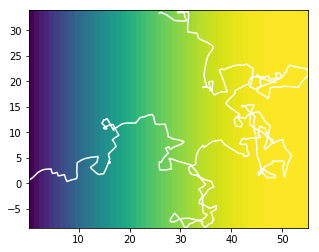

In [133]:
x = np.arange(np.min(xs),np.max(xs),1)
xx_grad = C0/(4*np.pi*d*D*duT)*np.exp(-(x-dis2targ)**2/(400*D*duT*50))
plt.imshow(np.expand_dims(xx_grad,axis=1).T,extent=[np.min(xs),np.max(xs),np.min(ys),np.max(ys)])
#plt.hold(True)
plt.plot(xs,ys,'white')

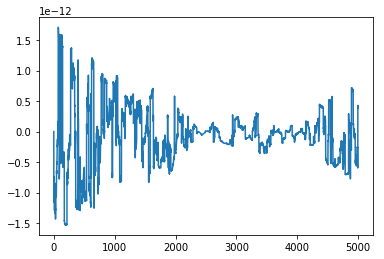

In [135]:
plt.plot(dcps)

In [136]:
# Set the parameters of the HMM
T = len(time) # number of time bins
K = 3    # number of discrete states
D = 2    # data dimension
M = 1    # input dimension
#C = 2    # number of output types/categories

# Make an HMM
true_hmm = HMM(K, D, M=M, 
               observations="autoregressive", #observation_kwargs=None,#dict(C=C),
               transitions="inputdriven")

# Optionally, turn up the input weights to exaggerate the effect
# true_hmm.transitions.Ws *= 3

# Create an exogenous input
#inpt = np.sin(2 * np.pi * np.arange(T) / 50)[:, None] + 1e-1 * npr.randn(T, M)
inpt = dcps.copy()[:,None]

# Sample some data from the HMM
z, y = true_hmm.sample(T, input=inpt)
#y = dths[:,None] #np.vstack([dths,xs]).T

# Compute the true log probability of the data, summing out the discrete states
true_lp = true_hmm.log_probability(y, inputs=inpt)

([<matplotlib.axis.YTick at 0x2b58b2631978>,
 <a list of 2 Text yticklabel objects>)

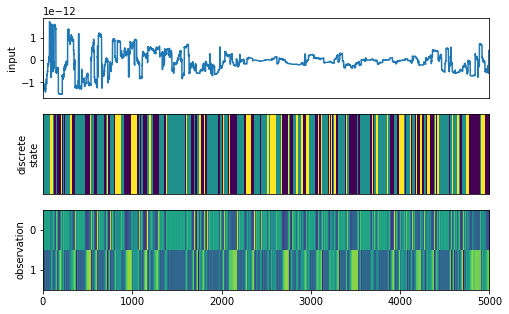

In [137]:
# Plot the data
plt.figure(figsize=(8, 5))

plt.subplot(311)
plt.plot(inpt)
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("input")

plt.subplot(312)
plt.imshow(z[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("discrete\nstate")
plt.yticks([])

plt.subplot(313)
#plt.imshow(one_hot(y[:,0], C).T, aspect="auto")
plt.imshow(y.T,aspect="auto")
plt.xlim(0, T)
plt.ylabel("observation")
plt.yticks(np.arange(C))

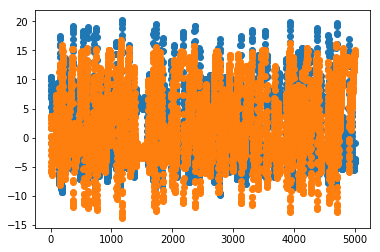

In [138]:
plt.plot(y,'o')

In [146]:
# Now create a new HMM and fit it to the data with EM
N_iters = 50
hmm = HMM(K, D, M=M, 
          observations="autoregressive",# observation_kwargs=dict(C=C),
          transitions="inputdriven")

y = np.vstack([xs,dths]).T  #dths[:,None] #
# Fit
hmm_lps = hmm.fit(y, inputs=inpt, method="em", num_em_iters=N_iters)

In [147]:
# Find a permutation of the states that best matches the true and inferred states
hmm.permute(find_permutation(z, hmm.most_likely_states(y, input=inpt)))
z_inf = hmm.most_likely_states(y, input=inpt)

Text(0, 0.5, 'Log Probability')

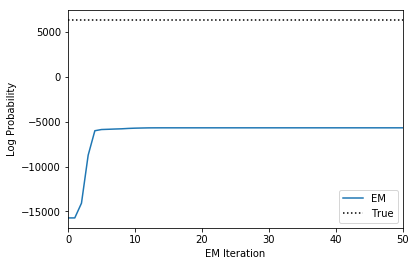

In [148]:
# Plot the log probabilities of the true and fit models
plt.plot(hmm_lps, label="EM")
plt.plot([0, N_iters], true_lp * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
plt.xlim(0, N_iters)
plt.ylabel("Log Probability")

([], <a list of 0 Text yticklabel objects>)

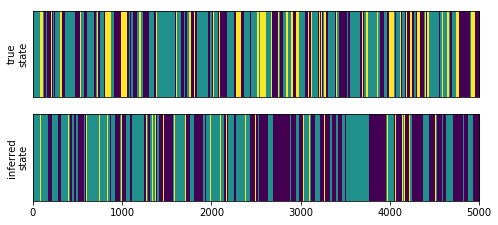

In [149]:
# Plot the true and inferred states
plt.figure(figsize=(8, 3.5))

plt.subplot(211)
plt.imshow(z[None, :], aspect="auto")
plt.xticks([])
plt.xlim(0, T)
plt.ylabel("true\nstate")
plt.yticks([])

plt.subplot(212)
plt.imshow(z_inf[None, :], aspect="auto")
plt.xlim(0, T)
plt.ylabel("inferred\nstate")
plt.yticks([])

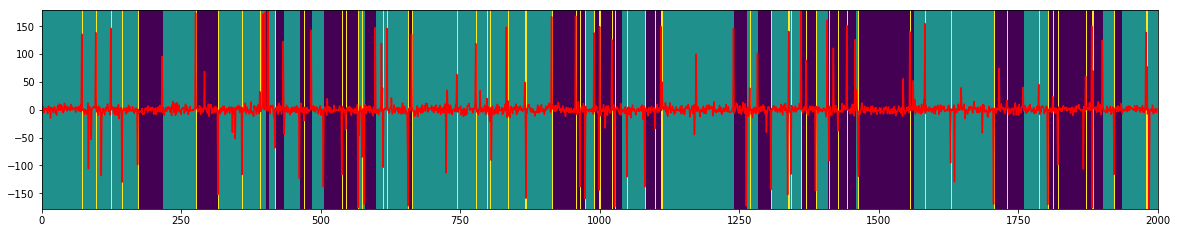

In [161]:
plt.figure(figsize=(20,10))
plt.plot(dths[:2000],'r')
plt.imshow(z_inf[:2000][:,None].T,extent=[0,2000,np.min(dths),np.max(dths)])

In [167]:
np.max(xs)

55.09705584029024

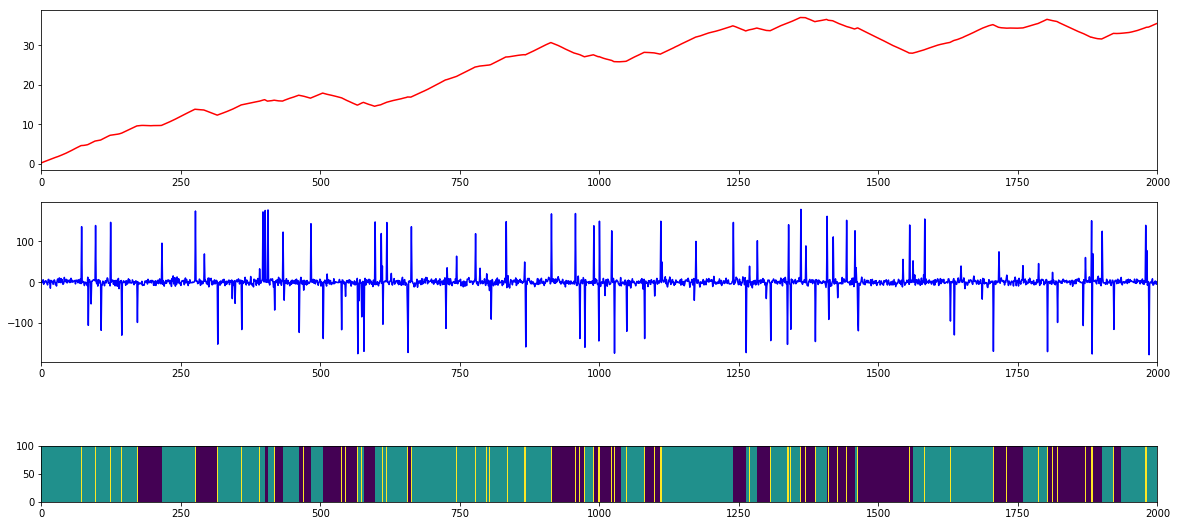

In [181]:
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(np.arange(0,2000),xs[:2000],'r')
plt.xlim(0,2000)
plt.subplot(312)
plt.plot(np.arange(0,2000),dths[:2000],'b')
plt.xlim(0,2000)
plt.subplot(313)
plt.imshow(z_inf[:2000][:,None].T,extent=[0,2000,0,100])

Text(0.5, 1.0, 'Inferred\nInput Weights')

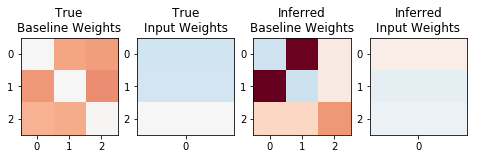

In [169]:
# Plot the true and inferred input effects
plt.figure(figsize=(8, 4))

vlim = max(abs(true_hmm.transitions.log_Ps).max(),
           abs(true_hmm.transitions.Ws).max(),
           abs(hmm.transitions.log_Ps).max(),
           abs(hmm.transitions.Ws).max())

plt.subplot(141)
plt.imshow(true_hmm.transitions.log_Ps, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(K))
plt.yticks(np.arange(K))
plt.title("True\nBaseline Weights")

plt.subplot(142)
plt.imshow(true_hmm.transitions.Ws, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=M/K)
plt.xticks(np.arange(M))
plt.yticks(np.arange(K))
plt.title("True\nInput Weights")

plt.subplot(143)
plt.imshow(hmm.transitions.log_Ps, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=1)
plt.xticks(np.arange(K))
plt.yticks(np.arange(K))
plt.title("Inferred\nBaseline Weights")

plt.subplot(144)
plt.imshow(hmm.transitions.Ws, vmin=-vlim, vmax=vlim, cmap="RdBu", aspect=M/K)
plt.xticks(np.arange(M))
plt.yticks(np.arange(K))
plt.title("Inferred\nInput Weights")